In [1]:
%load_ext autoreload
%autoreload 2

#Misc
import time, os, sys, pdb
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import pandas as pd
import scipy.stats as st

#Save
import json
import scipy.io as sio
import h5py

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
# cmap = usrplt.gradient_cmap(usrplt.color_palette)
sns.set_style("ticks")

#Model
import ssm

#User
import util
import plotting as usrplt


In [2]:
##===== Read in Data =====##
data_df = pd.read_hdf('./data/preparatory_movement_data.h5')
nTrials = len(data_df)
data_df.head()

,expdate,subject,condition,platform,distance,success,laser_trial,jump_time,trial,fps,...,Side LEar y,Top LEar y,Side LEar likelihood,Top LEar likelihood,Side TakeFL x,Top TakeFL x,Side TakeFL y,Top TakeFL y,Side TakeFL likelihood,Top TakeFL likelihood
0,061920,J157BLT,control,2,8,2,laser off,125,1,60,...,"[309.085771040483, 309.085771040483, 308.87452...","[296.588482140354, 295.88196968918214, 295.557...","[0.9999992847442627, 0.9999996423721313, 0.999...","[0.9999997615814209, 0.9999998807907104, 0.999...","[573.0687866210938, 573.0687866210938, 573.068...","[512.955810546875, 513.0393676757812, 513.0393...","[322.8341997502523, 322.61465629322106, 322.61...","[268.1868448211816, 267.6647500946191, 267.522...","[0.999998927116394, 0.9999992847442627, 0.9999...","[0.022194653749465942, 0.013417750597000122, 0..."
1,061920,J157BLT,control,1,20,2,laser off,222,2,60,...,"[321.2914378129316, 320.8449351273847, 320.844...","[299.88609963095644, 299.4508884493158, 298.10...","[0.9999973773956299, 0.9999958276748657, 0.999...","[0.9999992847442627, 0.9999996423721313, 0.999...","[572.3963012695312, 572.5952758789062, 572.698...","[522.5081787109375, 524.5397338867188, 525.219...","[322.1634885672048, 321.95636576447043, 321.90...","[312.353937981537, 311.36901366513075, 311.369...","[0.9999996423721313, 0.9999996423721313, 0.999...","[0.04482194781303406, 0.06799852848052979, 0.0..."
2,061920,J157BLT,control,3,8,1,laser off,355,3,60,...,"[292.9151773163767, 292.6319741913767, 291.174...","[252.98197382146657, 252.98197382146657, 252.9...","[0.9999998807907104, 0.9999998807907104, 0.999...","[0.9999997615814209, 0.9999997615814209, 0.999...","[572.5652465820312, 572.5652465820312, 572.565...","[524.19970703125, 524.19970703125, 524.1997070...","[321.70764668782556, 321.66675313313806, 321.3...","[290.35496151086056, 290.35496151086056, 289.4...","[0.9999998807907104, 0.9999998211860657, 0.999...","[0.8656889796257019, 0.7850416302680969, 0.630..."
3,061920,J157BLT,control,1,12,1,laser off,514,4,60,...,"[313.55253375600705, 313.2895332677258, 313.14...","[265.110596227482, 263.81851248724763, 263.649...","[0.9999997615814209, 0.9999995231628418, 0.999...","[0.9999972581863403, 0.9999987483024597, 0.999...","[573.1360473632812, 573.3661499023438, 573.473...","[1.9259750843048096, 265.081298828125, 528.512...","[323.10162814949797, 322.54117282723234, 322.3...","[333.40595751365845, 284.7679875429553, 284.76...","[0.9999951720237732, 0.9999984502792358, 0.999...","[0.004946380853652954, 0.004948854446411133, 0..."
4,061920,J157BLT,control,2,12,0,laser off,651,5,60,...,"[313.9351677623222, 312.51375052599406, 310.65...","[244.44779596096134, 244.44779596096134, 244.4...","[1.0, 0.9999998807907104, 0.9999995231628418, ...","[0.9999991655349731, 0.9999986886978149, 0.999...","[572.7760009765625, 573.4033813476562, 573.407...","[522.1571655273438, 522.1571655273438, 522.157...","[320.158985665174, 319.99281745228336, 319.964...","[291.3589452728023, 291.3589452728023, 291.358...","[0.9999997615814209, 0.9999998807907104, 0.999...","[0.9386019706726074, 0.956940770149231, 0.9827..."


In [3]:
#DLC tracking confidence threshold at which to mask out data
confidence_threshold = 0.8

#Loop over trials and reformat data for ARHMM
data_list = []; mask_list = []
for iTrial in range(nTrials):
    #Get coordinates of Take-Off platform
    xc = np.nanmean(data_df.loc[iTrial]['Side TakeFL x'])
    yc = np.nanmean(data_df.loc[iTrial]['Side TakeFL y'])
    
    xy_list = []; ll_list = []
    for ii, ptstr in enumerate(['Nose','LEye','LEar']):
        x = data_df.loc[iTrial]['Side {} x'.format(ptstr)]
        y = data_df.loc[iTrial]['Side {} y'.format(ptstr)]
        llhood = data_df.loc[iTrial]['Side {} likelihood'.format(ptstr)]
        
        #Coordinates relative to take-off platform
        xy_list.append((x-xc,y-yc))
        
        #Create mask for points that have a confidence lower than the given threshold
        mask = llhood > confidence_threshold
        ll_list.append((mask,mask))
    
    data_list.append(np.vstack(xy_list).T)
    mask_list.append(np.vstack(ll_list).T)


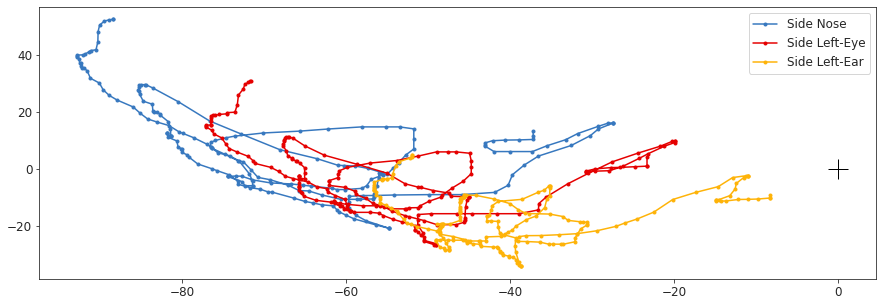

In [4]:
iTrial = 95
fig, ax = plt.subplots(figsize=(15,5))

#Plot traces
ax.plot(data_list[iTrial][:,0],data_list[iTrial][:,1],'.-',color=usrplt.cc[0],label='Side Nose')
ax.plot(data_list[iTrial][:,2],data_list[iTrial][:,3],'.-',color=usrplt.cc[1],label='Side Left-Eye')
ax.plot(data_list[iTrial][:,4],data_list[iTrial][:,5],'.-',color=usrplt.cc[2],label='Side Left-Ear')

# dObs, nT = data_list[iTrial].shape
# #Connect Tracking to give sense of angle
# line_segments = LineCollection([[data_list[iTrial][0:2,i],data_list[iTrial][2:4,i]] for i in range(nT)],colors=usrplt.cc[8],alpha=0.5, linestyle='solid')
# ax.add_collection(line_segments)
# line_segments = LineCollection([[data_list[iTrial][2:4,i],data_list[iTrial][4:,i]] for i in range(nT)],colors=usrplt.cc[8],alpha=0.5, linestyle='solid')
# ax.add_collection(line_segments)

ax.legend()
ax.plot(0,0,'+k',ms=20)
# x = data_df.loc[iExp]['Side TakeFL x']; y = data_df.loc[iExp]['Side TakeFL y']; confidence = data_df.loc[iExp]['Side TakeFL likelihood']
# indy = np.where(confidence > 0.8)[0]
# ax.plot(x[indy],y[indy],'.k',label='Side TakeFL')

In [26]:
1/60

0.016666666666666666

In [6]:
##===== Fit ARHMM to data =====##
_, dObs = data_list[0].shape

#HMM parameters
#Let's start with 10 states
K = 10
N_iters=200

#Initialize basic ARHMM object 
#lots of parameters we can change; 
# we can make the transitions sticky or change the probability of transition given some external input;
# we can also change the observation class to "robust_autoregressive", which 
arhmm = ssm.HMM(K, dObs, transitions='sticky', observations="autoregressive") 

#Fit model to data
hmm_lls = arhmm.fit(data_list, method="em", num_iters=N_iters,tolerance=1E-6)

In [21]:
arhmm.observations.Sigmas.shape

(10, 6, 0)

<AxesSubplot:>

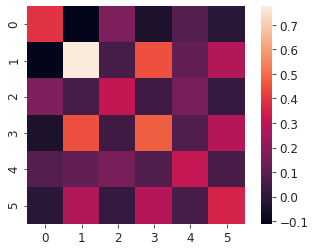

In [23]:
sns.heatmap(arhmm.observations.Sigmas[8],square=True)

In [18]:
dir(arhmm.observations)

['A',
 'As',
 'D',
 'J0',
 'K',
 'M',
 'Psi0',
 'Sigmas',
 'Sigmas_init',
 'Vs',
 '_As',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_compute_mus',
 '_extend_given_sufficient_statistics',
 '_get_sufficient_statistics',
 '_sqrt_Sigmas',
 '_sqrt_Sigmas_init',
 'b',
 'bs',
 'h0',
 'initialize',
 'lags',
 'log_likelihoods',
 'log_prior',
 'm_step',
 'mu_init',
 'neg_hessian_expected_log_dynamics_prob',
 'nu0',
 'params',
 'permute',
 'sample_x',
 'smooth']

In [13]:
color_names_K = usrplt.color_names[:K]; color_names_K.append(usrplt.color_names[-1])
color_palette = sns.xkcd_palette(color_names_K)
cmap = usrplt.gradient_cmap(sns.xkcd_palette(usrplt.color_names[:K]))

In [60]:
#Loop over trials and get the maximum a posteriori probability estimate of the latent states
MAP_list = []; posterior_list = []; mask_list = []

for data in data_list:
    expected_states, expected_joints, log_likes = arhmm.expected_states(data)

    MAP_list.append(np.argmax(expected_states,axis=1))
    posterior_list.append(expected_states)
    mask_list.append(np.max(expected_states,axis=1) > 0.8)


In [63]:
MAP_list[2]

array([4, 4, 4, 5, 5, 8, 8, 8, 8, 8, 8, 8, 0, 0, 4, 4, 5, 5, 4, 4, 0, 2,
       2, 0, 4, 5, 0, 0, 2, 8, 2, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0,
       4, 6, 0, 2, 2, 2, 2, 2, 2, 8, 8, 2, 6, 0, 6, 6, 4, 0, 0, 8, 2, 0,
       0, 5, 4, 4, 0, 0, 2, 2, 2, 8, 8, 8, 2, 6, 6, 0, 6, 6, 2, 6, 6, 0,
       6, 6, 4, 4, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 6, 6, 2, 2,
       6, 6, 6, 6, 4, 4, 0, 0, 2, 2, 2, 2, 2, 0, 0, 6, 4, 0, 0, 6, 2, 2])

In [28]:
##===== Let's find the average starting position =====##
initial_positions = []
for data in data_list:
    initial_positions.append(data[0,:])
initial_positions = np.array(initial_positions)

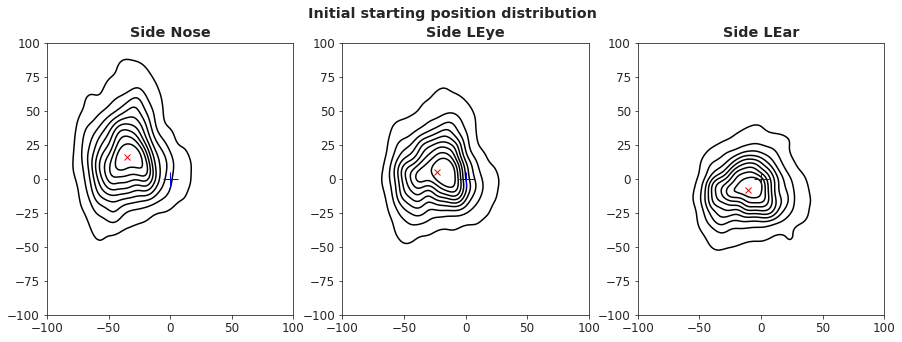

In [32]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
plt.suptitle('Initial starting position distribution')

for ii, ptstr in enumerate(['Nose','LEye','LEar']):
    ax = axes[ii]
    sns.kdeplot(x=initial_positions[:,2*ii],y=initial_positions[:,ii*2+1],color='k',ax=ax)
#     indy = np.random.randint(0, high=nTrials, size=100)
#     ax.plot(initial_positions[indy,2*ii],initial_positions[indy,ii*2+1],'.r')
    ax.plot(np.mean(initial_positions[:,2*ii],axis=0),np.mean(initial_positions[:,ii*2+1],axis=0),'xr')
    ax.set_title('Side {}'.format(ptstr))
    ax.plot(0,0,'+b',ms=15)
    ax.set_xlim([-100,100]); ax.set_ylim([-100,100])

In [64]:
int_state = []
for mapseq in MAP_list:
    int_state.append(mapseq[0])

In [65]:
np.unique(int_state,return_counts=True)

(array([1, 4, 5, 6]), array([ 672, 2437, 1154,    1]))

In [ ]:

#Connect Tracking to give sense of angle
line_segments = LineCollection([[data_list[iTrial][0:2,i],data_list[iTrial][2:4,i]] for i in range(nT)],colors=usrplt.cc[8],alpha=0.5, linestyle='solid')
ax.add_collection(line_segments)

line_segments = LineCollection([[data_list[iTrial][2:4,i],data_list[iTrial][4:,i]] for i in range(nT)],colors=usrplt.cc[8],alpha=0.5, linestyle='solid')
ax.add_collection(line_segments)

(-100.0, 100.0)

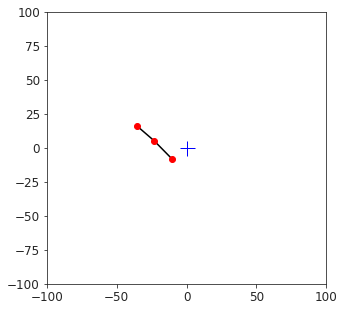

In [48]:
mean_initial_position = np.mean(initial_positions,axis=0)
fig, ax = plt.subplots(figsize=(5,5))

plt.plot([mean_initial_position[0],mean_initial_position[2]],[mean_initial_position[1],mean_initial_position[3]],'-k')
plt.plot([mean_initial_position[2],mean_initial_position[4]],[mean_initial_position[3],mean_initial_position[5]],'-k')
for ii, ptstr in enumerate(['Nose','LEye','LEar']):
    ax.plot(mean_initial_position[2*ii],mean_initial_position[ii*2+1],'or')
    
ax.plot(0,0,'+b',ms=15)
ax.set_xlim([-100,100]); ax.set_ylim([-100,100])

In [25]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
plt.suptitle('State {} Dynamics'.format(iState))

for ii, ptstr in enumerate(['Nose','LEye','LEar']):
    AR = arhmm.observations.As[iState,slice(ii*2,(ii+1)*2),slice(ii*2,(ii+1)*2)]
    bias = arhmm.observations.bs[iState,slice(ii*2,(ii+1)*2)]

    usrplt.plot_dynamics_2d(AR,bias,mins=(-100,-100),maxs=(100,100),npts=15,axis=axes[ii],color=usrplt.cc[iState])
    axes[ii].set_title('Side {}'.format(ptstr))
    axes[ii].set_xlim([-100,100]); axes[ii].set_ylim([-100,100])
    axes[ii].plot(0,0,'+k',ms=15)

(4264, 6)

In [17]:
##===== Save state sequences =====##
fpath = './results/preparatory_behavior_K-{}_rARHMM.mat'.format(K)
sio.savemat(fpath,{'MAP_list': MAP_list, 'posterior_list': posterior_list,'mask_list': mask_list})

/home/dwyrick/miniconda3/envs/ssm/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [210]:
K = 10
tmp_data = sio.loadmat('./results/preparatory_behavior_K-{}_ARHMM.mat'.format(K))
MAP_list = tmp_data['MAP_list'][0]
posterior_list = tmp_data['posterior_list'][0]
mask_list = tmp_data['mask_list'][0]

4264

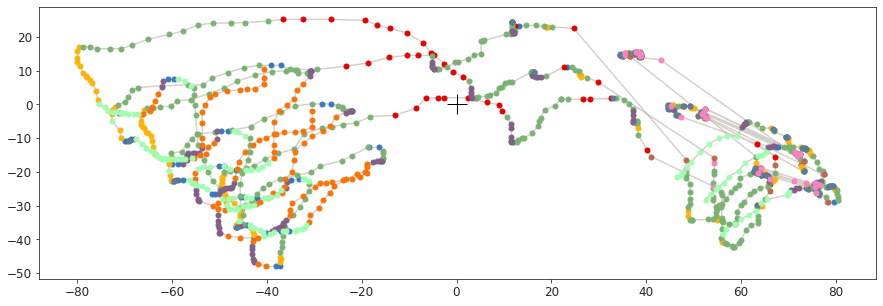

In [15]:
##===== Let's look at the states! =====##
iTrial = 5
mapseq = MAP_list[iTrial]
data = data_list[iTrial]

fig, ax = plt.subplots(figsize=(15,5))

ax.plot(data_list[iTrial][:,0],data_list[iTrial][:,1],'-',color=usrplt.cc[-1],alpha=0.5)
ax.plot(data_list[iTrial][:,2],data_list[iTrial][:,3],'-',color=usrplt.cc[-1],alpha=0.5)
ax.plot(data_list[iTrial][:,4],data_list[iTrial][:,5],'-',color=usrplt.cc[-1],alpha=0.5)

for state in np.unique(mapseq):
    indy = np.where(mapseq == state)[0]
    #Plot traces
    ax.plot(data[indy,0],data[indy,1],'.',color=usrplt.cc[state],ms=10)
    ax.plot(data[indy,2],data[indy,3],'.',color=usrplt.cc[state],ms=10)
    ax.plot(data[indy,4],data[indy,5],'.',color=usrplt.cc[state],ms=10)

ax.plot(0,0,'+k',ms=20)


In [ ]:
##===== Let's visualize the dynamics of each state  =====##
for iState in range(K):
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    plt.suptitle('State {} Dynamics'.format(iState))
    
    indy = np.random.randint(0, nTrials,nTrials_to_plot)
    
    ax.plot(0,0,'+k',ms=20)
    for iTrial in indy:
        mapseq = MAP_list[iTrial]
        data = data_list[iTrial]
        indy = np.where(mapseq == state)[0]
        #Plot nose traces
        ax.plot(data[indy,0],data[indy,1],'.',color=usrplt.cc[state],ms=5)
    ax.set_xlim([-100,100])
    ax.set_ylim([-100,100])


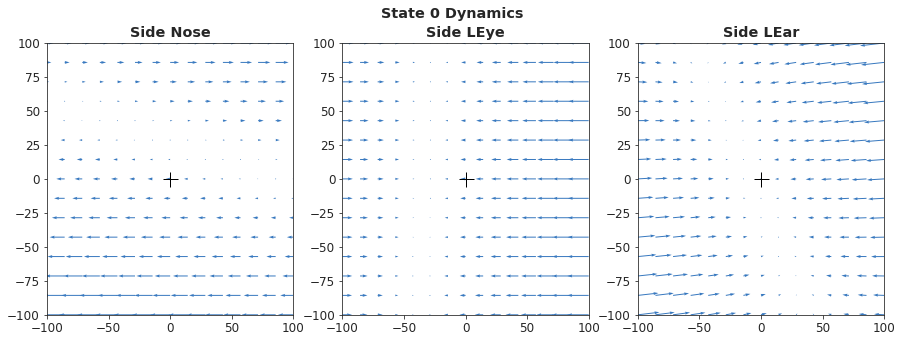

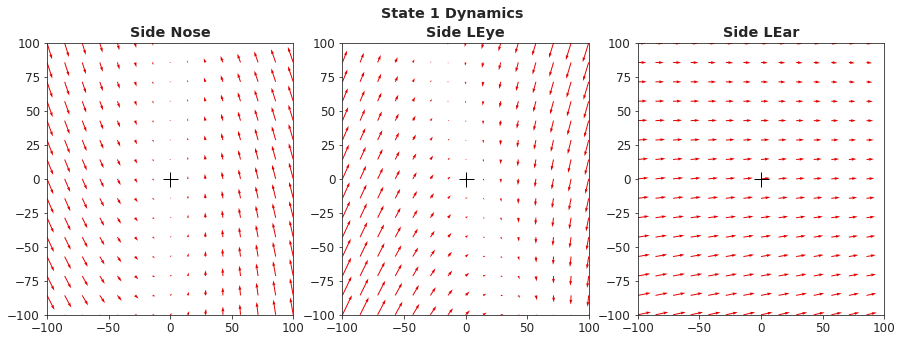

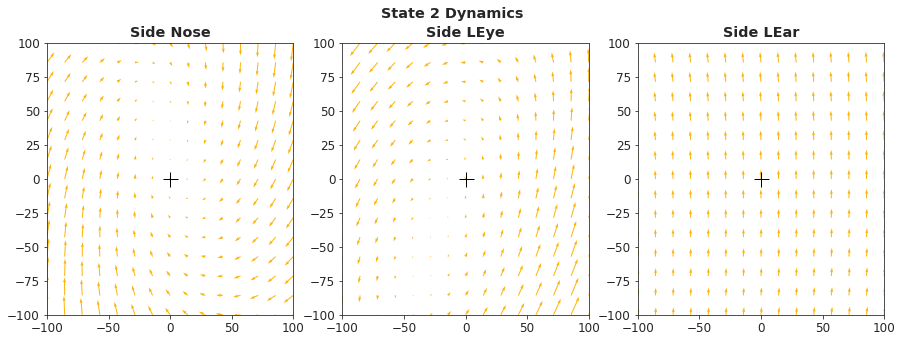

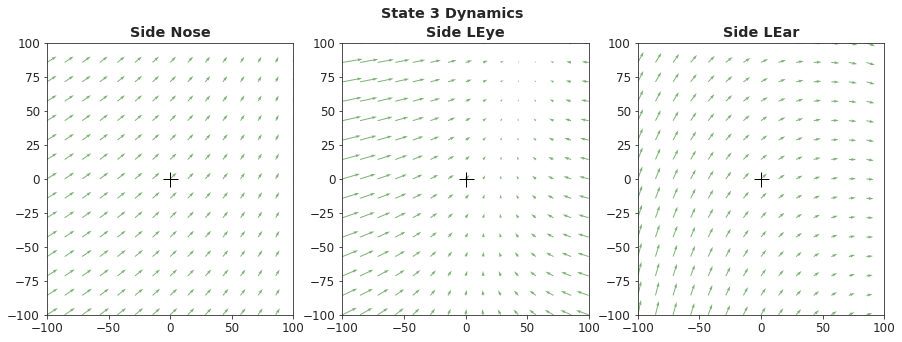

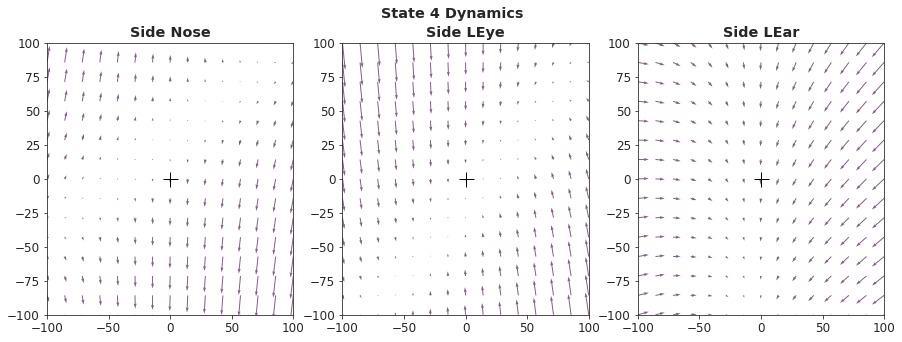

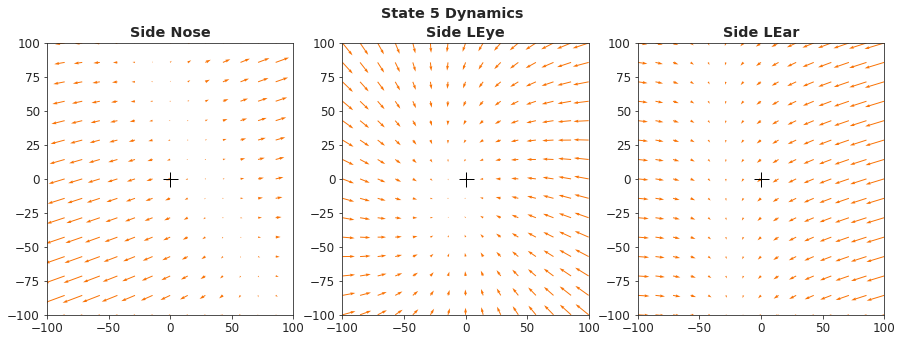

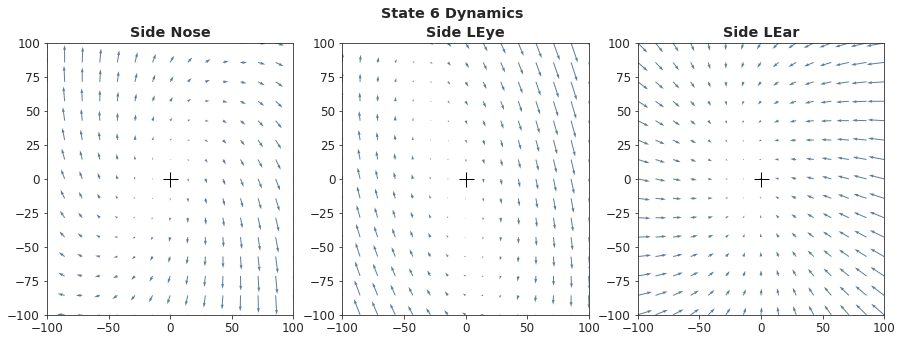

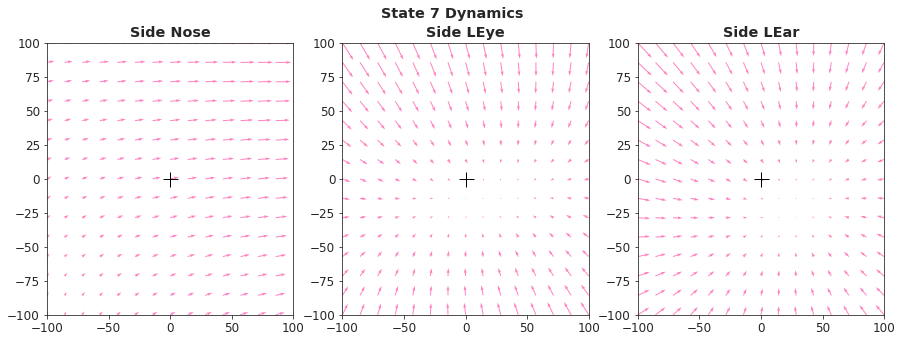

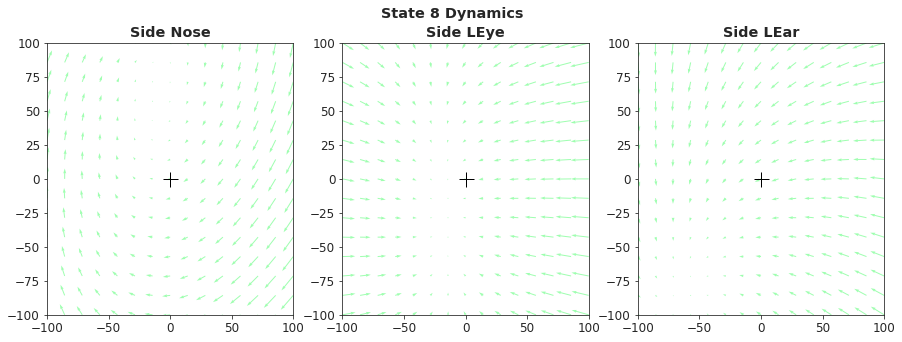

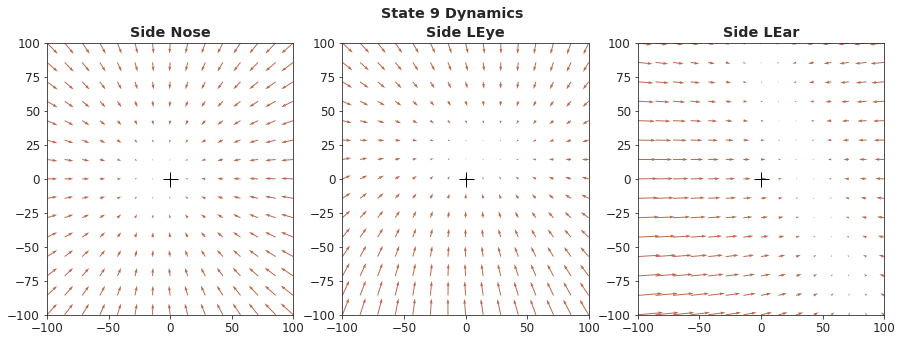

In [16]:
##===== Let's visualize the dynamics of each state  =====##
for iState in range(K):
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    plt.suptitle('State {} Dynamics'.format(iState))

    for ii, ptstr in enumerate(['Nose','LEye','LEar']):
        AR = arhmm.observations.As[iState,slice(ii*2,(ii+1)*2),slice(ii*2,(ii+1)*2)]
        bias = arhmm.observations.bs[iState,slice(ii*2,(ii+1)*2)]
        
        usrplt.plot_dynamics_2d(AR,bias,mins=(-100,-100),maxs=(100,100),npts=15,axis=axes[ii],color=usrplt.cc[iState])
        axes[ii].set_title('Side {}'.format(ptstr))
        axes[ii].set_xlim([-100,100]); axes[ii].set_ylim([-100,100])
        axes[ii].plot(0,0,'+k',ms=15)

In [54]:
##===== Fit 2D gaussian to location where state is used =====##

nTrials_to_plot = 100
for iState in range(K):
    print(iState)
    sloc = state_locations[iState]
    for ii, ptstr in enumerate(['Nose','LEye','LEar']):
        xs = sloc[:,2*ii]; ys = sloc[:,2*ii+1]
        print('\t{}: x [{:.1f},{:.1f}] y [{:.1f},{:.1f}]'.format(ptstr,np.mean(xs)-np.std(xs),np.mean(xs)+np.std(xs),np.mean(ys)-np.std(ys),np.mean(ys)-np.std(ys)))
        



0
	Nose: x [-87.1,123.3] y [-77.6,-77.6]
	LEye: x [-21.0,122.1] y [-72.7,-72.7]
	LEar: x [-42.5,127.4] y [-92.0,-92.0]
1
	Nose: x [-77.8,-7.8] y [-21.9,-21.9]
	LEye: x [-67.2,0.6] y [-30.5,-30.5]
	LEar: x [-55.1,11.8] y [-42.0,-42.0]
2
	Nose: x [-72.0,3.5] y [-26.1,-26.1]
	LEye: x [-60.8,11.9] y [-31.4,-31.4]
	LEar: x [-52.2,22.5] y [-48.6,-48.6]
3
	Nose: x [-85.4,-8.9] y [-23.5,-23.5]
	LEye: x [-74.3,-0.4] y [-31.4,-31.4]
	LEar: x [-61.0,10.4] y [-46.9,-46.9]
4
	Nose: x [-65.1,-29.9] y [-23.1,-23.1]
	LEye: x [-55.8,-21.3] y [-30.2,-30.2]
	LEar: x [-44.3,-10.6] y [-39.4,-39.4]
5
	Nose: x [-61.8,31.2] y [-29.9,-29.9]
	LEye: x [-52.3,38.9] y [-36.2,-36.2]
	LEar: x [-42.8,54.3] y [-53.7,-53.7]
6
	Nose: x [-30.0,65.0] y [-36.1,-36.1]
	LEye: x [-25.6,72.4] y [-42.1,-42.1]
	LEar: x [-15.5,87.5] y [-57.8,-57.8]
7
	Nose: x [-87.0,-19.3] y [-21.2,-21.2]
	LEye: x [-74.4,-10.2] y [-29.9,-29.9]
	LEar: x [-60.2,1.2] y [-42.2,-42.2]
8
	Nose: x [-82.7,-50.2] y [-19.7,-19.7]
	LEye: x [-69.1,-40.3] y [

In [49]:
##===== Fit 2D gaussian to location where state is used =====##
state_locations = []
nTrials_to_plot = 100
for state in range(K):
#     fig, ax = plt.subplots(figsize=(8,8))
    
    tmp = []
    for data, mapseq in zip(data_list,MAP_list):
        indy = np.where(mapseq == state)[0]
        if len(indy) == 0:
            continue
        tmp.append(data[indy,:])
    
    state_locations.append(np.concatenate(tmp))




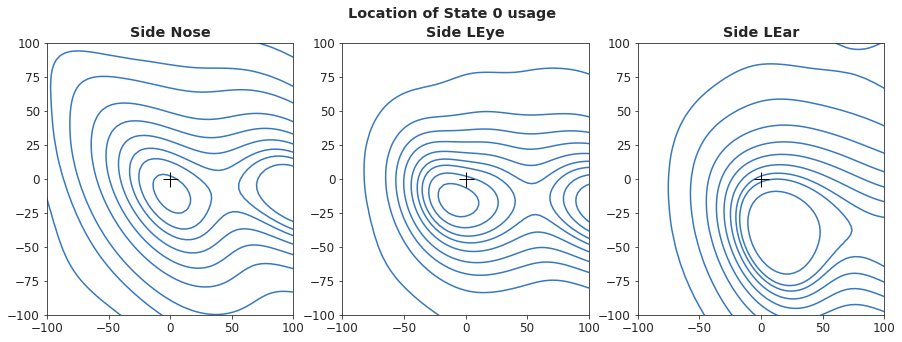

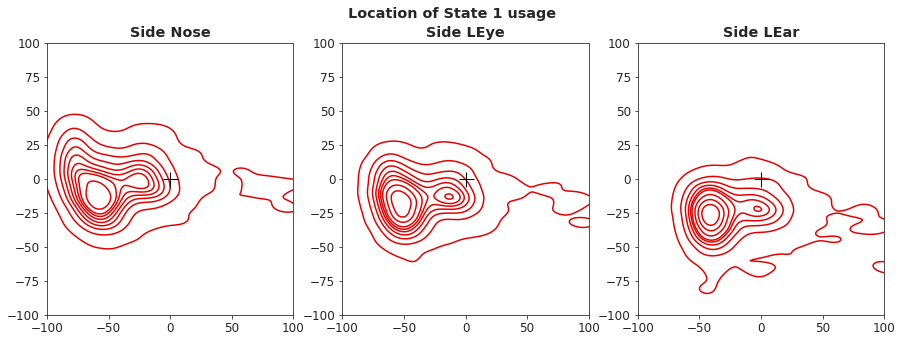

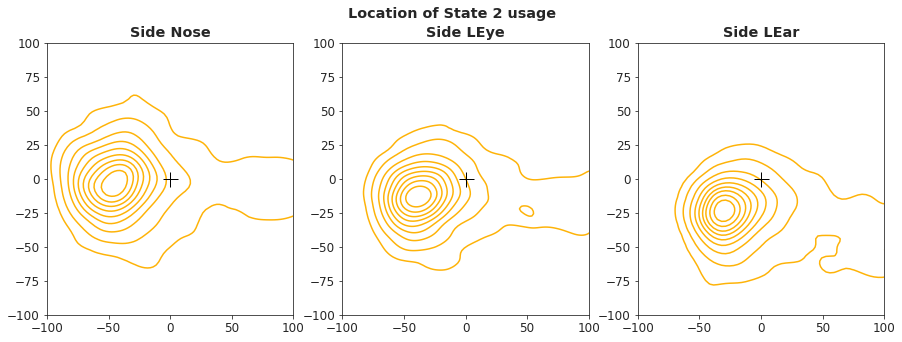

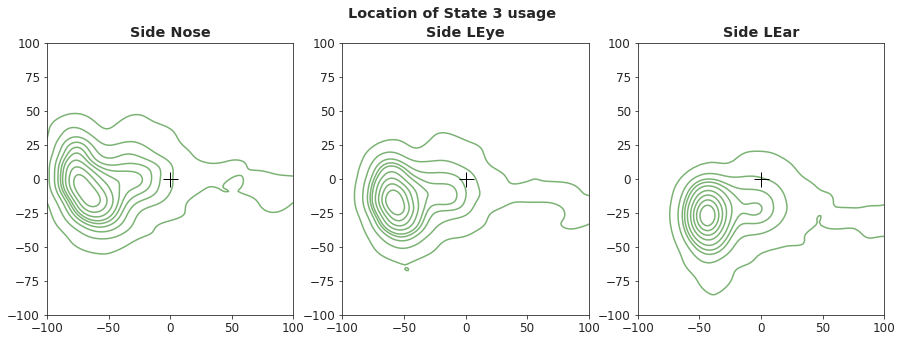

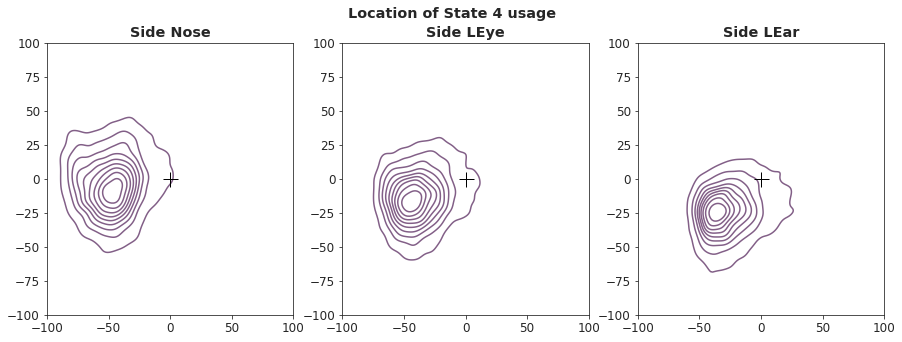

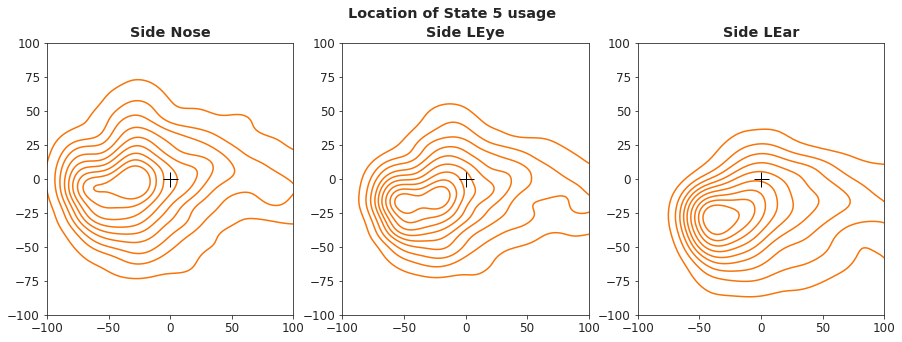

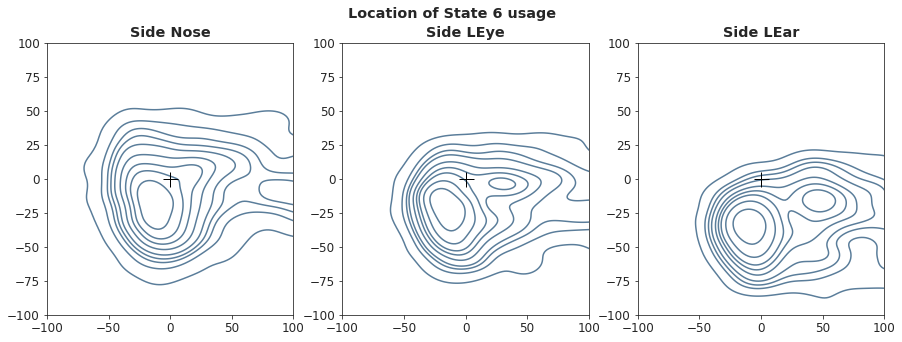

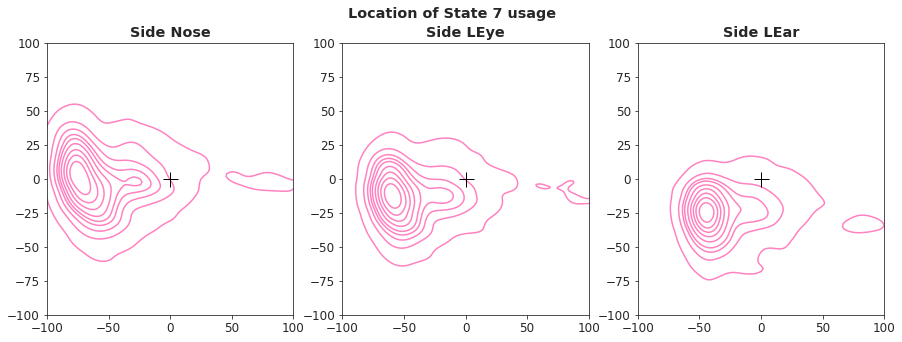

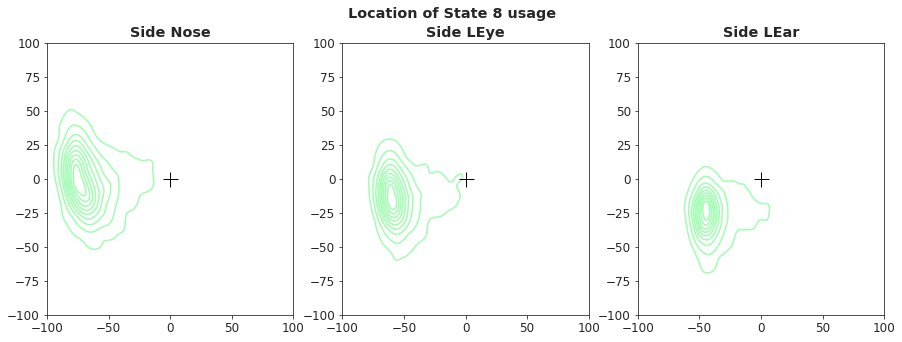

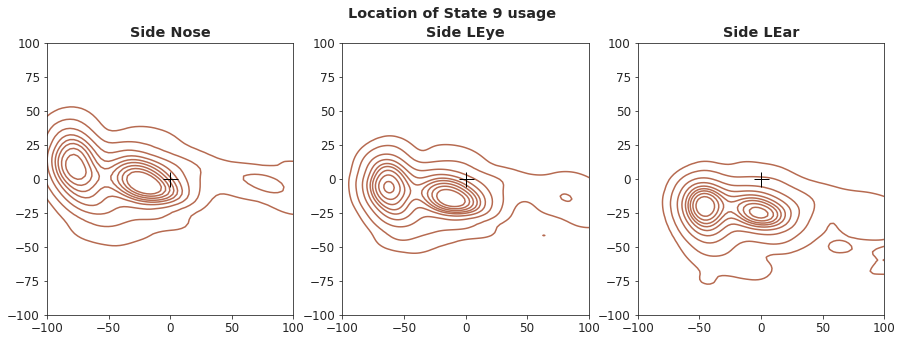

In [46]:

for iState in range(K):
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    plt.suptitle('Location of State {} usage'.format(iState))
    nBins, _ = state_locations[iState].shape
    sloc = state_locations[iState]
    if nBins < 5000:
        indy = np.arange(nBins)
    else:
        indy = np.random.randint(0, high=nBins, size=5000)
        
    for ii, ptstr in enumerate(['Nose','LEye','LEar']):
        ax = axes[ii]
        sns.kdeplot(x=sloc[indy,2*ii],y=sloc[indy,ii*2+1],color=usrplt.cc[iState],ax=ax)
        ax.set_title('Side {}'.format(ptstr))
        ax.plot(0,0,'+k',ms=15)
        ax.set_xlim([-100,100]); ax.set_ylim([-100,100])
    
    
    

In [40]:
#Calculate state duration and state usage 
state_duration_list, state_usage_list, state_usage = util.get_state_durations(MAP_list, mask_list, K)

/home/dwyrick/miniconda3/envs/ssm/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5'),
 Text(6, 0, '6'),
 Text(7, 0, '7'),
 Text(8, 0, '8'),
 Text(9, 0, '9'),
 Text(10, 0, 'NaN')]

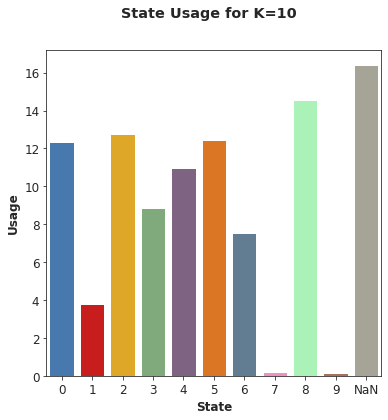

In [41]:
fig,ax = plt.subplots(figsize=(6,6))
plt.suptitle('State Usage for K={}'.format(K))

sns.barplot(np.arange(K+1),state_usage*100,palette=color_palette,ax=ax)
ax.set_xlabel('State')
ax.set_ylabel('Usage',fontsize=12)

tmp = [str(i) for i in np.arange(K)]
tmp.append('NaN')
ax.set_xticklabels(tmp)

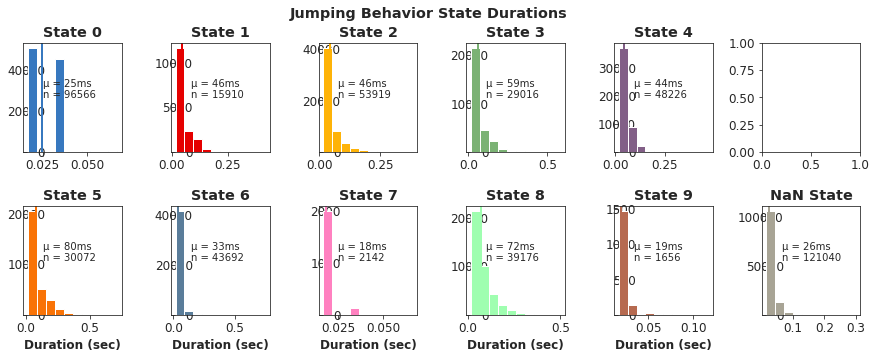

In [42]:
usrplt.plot_state_durations(state_duration_list, K)

In [58]:
1/60

0.016666666666666666

<AxesSubplot:title={'center':'State Transition Matrix for ARHMM'}>

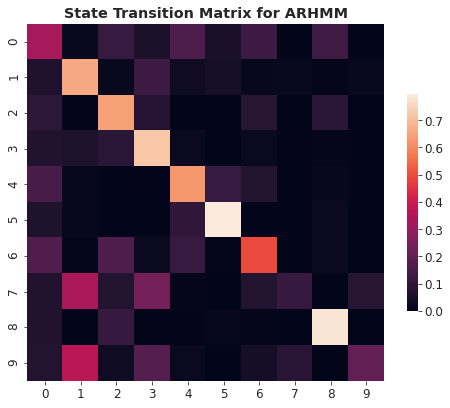

In [43]:
plt.figure(figsize = (8,8))
plt.title('State Transition Matrix for ARHMM')
transition_matrix = arhmm.transitions.transition_matrix
# transition_matrix[np.diag_indices(K)] = np.nan
sns.heatmap(transition_matrix,square=True,cbar_kws={'shrink':0.5})

In [157]:
MAP_list_sorted = sorted(MAP_list, key=len)[::-1]
mask_list_sorted = sorted(mask_list, key=len)[::-1]

In [176]:
len(MAP_list_sorted[1])

3809

In [191]:
max_trial_length = len(MAP_list_sorted[100])

#Let's look at the 500 longest state sequences together in a 
zs = np.zeros((200,max_trial_length)); zs[:] = np.nan

for iTrial in range(200):
    indy = np.where(mask_list_sorted[iTrial+100])
    mapseq = MAP_list_sorted[iTrial+100]
    nT = len(mapseq)
    zs[iTrial,indy] = mapseq[indy]


In [58]:
mapseq[0]

-1

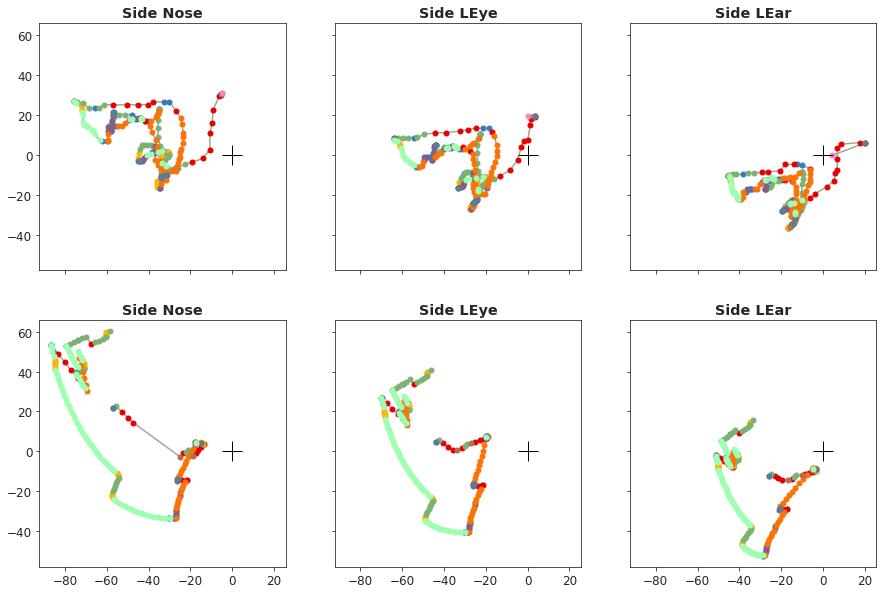

In [142]:
iTrial = 0
mapseq = MAP_list[iTrial]
data = data_list[iTrial]

nT,_ = data.shape



fig, axes = plt.subplots(2,3,figsize=(15,10),sharex='all', sharey='all' )

#Plot actual traces 
for jj,ptstr in enumerate(['Nose','LEye','LEar']):
    ax = axes[0,jj]
    ax.set_title('Side {}'.format(ptstr))
    ax.plot(data[:,jj*2],data[:,jj*2+1],'-',color=usrplt.cc[-1])
    for state in np.unique(mapseq):
        indy = np.where(mapseq == state)[0]
        #Plot traces
        ax.plot(data[indy,jj*2],data[indy,jj*2+1],'.',color=usrplt.cc[state],ms=10)

    ax.plot(0,0,'+k',ms=20)

# start_state = (np.array([4],dtype=int),mean_initial_position.reshape(1,dObs))
start_state = (np.array([mapseq[0]],dtype=int),data[0,:].reshape(1,dObs))
z_sim, data_sim = arhmm.sample(nT,prefix=start_state,with_noise=False)

#Plot simulated traces
for jj,ptstr in enumerate(['Nose','LEye','LEar']):
    ax = axes[1,jj]
    ax.set_title('Side {}'.format(ptstr))
    ax.plot(data_sim[:,jj*2],data_sim[:,jj*2+1],'-',color=usrplt.cc[-1])
    for state in np.unique(z_sim):
        indy = np.where(z_sim == state)[0]
        #Plot traces
        ax.plot(data_sim[indy,jj*2],data_sim[indy,jj*2+1],'.',color=usrplt.cc[state],ms=10)

    ax.plot(0,0,'+k',ms=20)

plt.savefig('./plots/simulated-vs-actual_trajectories_trial{:03d}.png'.format(iTrial))
